# Logisitic Regression and Support Vector Machines Minilab

You are to perform predictive analysis (classification) upon a data set: model the dataset using methods we have discussed in class: logistic regression and support vector machines, and making conclusions from the analysis. Follow the CRISP-DM framework in your analysis (you are not performing all of the CRISP-DM outline, only the portions relevant to the grading rubric outlined below). This report is worth 10% of the final grade. You may complete this assignment in teams of as many as three people.  




By Martin Garcia, Joanna Duran, Daniel Byrne

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random

from sklearn.linear_model import SGDClassifier
from sklearn import svm

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Business Understanding

Our objective is to create a logistic regression model and a support vector machine model for the classification of each image. We will determine which is a better model based on prediction accuracy, training time, and efficiency.The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6,000 images per class. 

Our objective is to create a logistic regression model and a support vector machine model for the classification of each image in our test set. We will determine which model is best suited for this standard classification task based on a comparison on their prediction accuracy, training times, and computational efficiency.

## Data Meaning Type

### The CIFAR-10 dataset

We are using the [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset which consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. The dataset includes are 50000(80%) training images and 10000(20%) test images broken in to 5 pre-randomized training batches and 1 test batch.

Each training batch contains 10,000 observations with a row vector of length 3072 representative of color image of 32x32 pixels. The first 1024 columns consist of red values, followed by green, and blue. The data also incorporates labels ranging from 0 to 9 and are listed below.

* airplane : 0
* automobile : 1
* bird : 2
* cat : 3
* deer : 4
* dog : 5
* frog : 6
* horse : 7
* ship : 8
* truck : 9

The test batch contains 1000 randomly-selected images from each class. The 5 training batches are randomized and contain a variable number of images from each class. 

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

## Simple Statistics

In [2]:
#load the data, reshape to 32x32 matrix per color, transpose matrices
def load_cfar10_batch(path, batch_id = None, reshape = True):
    """
    Argument:
    path -- path the datasets
    batch_id -- id of the batch (1 to 5) to load
    
    Returns:
    parameters -- python dictionary containing:
                    X -- features
                    Y -- labels
    """
    if batch_id is not None:
        filepath = path + 'data_batch_' + str(batch_id)
    else:
        filepath = path
        
    with open(filepath, mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
    
    if reshape:    
        X = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
        Y = np.array(batch['labels'])
    else:
        X = batch['data']
        Y = np.array(batch['labels'])
        
    return X, Y


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 4097:
Image - Min Value: 44 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


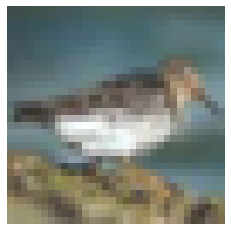

In [3]:
#load labels for our label
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#display images
def display_stats(data, batch_id, sample_id):
    features, labels = load_cfar10_batch(data, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))

    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)

batch_id = random.randint(1,5)
sample_id = random.randint(1,10000)
display_stats( "data/", batch_id, sample_id)

## Models

In this section we will create a logistic regression model and a support vector machine model for the classification task involved with your dataset.  We will assess how well each model performs (use 80/20 training/testing split)and adjust parameters of the models to make them more accurate. 

### Logistic Regression Model

In [4]:
# Build Logistic Regression Model with Stochastic Gradient Descent 
X,Y = load_cfar10_batch("data/",1,False)

for n in range(2,6):
    x,y = load_cfar10_batch("data/",n,False)
    X = np.concatenate((X,x),axis=0)
    Y = np.concatenate((Y,y),axis=0)

test_X,test_Y = load_cfar10_batch("data/test_batch",None,False)
#labelnames = unpickle("data/batches.meta")

sgdlr = SGDClassifier(alpha=0.001, max_iter=10000, tol=1e-3, verbose = 1,n_jobs=4,loss="log")

print("Data shape: ",X.shape)
print("Labels shape: ",Y.shape)

print("Test Data shape: ",test_X.shape)
print("Test Labels shape: ",test_Y.shape)



Data shape:  (50000, 3072)
Labels shape:  (50000,)
Test Data shape:  (10000, 3072)
Test Labels shape:  (10000,)


In [ ]:
sgdlr.fit(X,Y)
score = sgdlr.score(test_X,test_Y)
print(score)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


-- Epoch 1-- Epoch 1
-- Epoch 1

-- Epoch 1
Norm: 2921.69, NNZs: 3072, Bias: -6.603061, T: 50000, Avg. loss: 423510.589416
Total training time: 0.34 seconds.
-- Epoch 2
Norm: 2241.97, NNZs: 3072, Bias: -7.512332, T: 50000, Avg. loss: 475570.319952
Total training time: 0.34 seconds.
-- Epoch 2
Norm: 1986.92, NNZs: 3072, Bias: -17.182976, T: 50000, Avg. loss: 475364.134868
Total training time: 0.34 seconds.
-- Epoch 2
Norm: 2474.71, NNZs: 3072, Bias: -58.313940, T: 50000, Avg. loss: 559808.534897
Total training time: 0.36 seconds.
-- Epoch 2
Norm: 1748.16, NNZs: 3072, Bias: -7.513071, T: 100000, Avg. loss: 52317.068622
Total training time: 0.73 seconds.
-- Epoch 3
Norm: 1467.65, NNZs: 3072, Bias: -8.297116, T: 100000, Avg. loss: 62484.280555
Total training time: 0.75 seconds.
-- Epoch 3
Norm: 1268.92, NNZs: 3072, Bias: -17.966882, T: 100000, Avg. loss: 62231.211852
Total training time: 0.75 seconds.
-- Epoch 3
Norm: 1589.64, NNZs: 3072, Bias: -65.493090, T: 100000, Avg. loss: 71978.22389

Norm: 467.02, NNZs: 3072, Bias: -88.104962, T: 850000, Avg. loss: 6177.085402
Total training time: 7.40 seconds.
-- Epoch 18
Norm: 400.73, NNZs: 3072, Bias: -20.734812, T: 850000, Avg. loss: 5349.618966
Total training time: 7.42 seconds.
-- Epoch 18
Norm: 434.49, NNZs: 3072, Bias: -11.443969, T: 850000, Avg. loss: 5377.317781
Total training time: 7.51 seconds.
-- Epoch 18
Norm: 462.16, NNZs: 3072, Bias: -10.796399, T: 900000, Avg. loss: 4074.408533
Total training time: 7.66 seconds.
-- Epoch 19
Norm: 454.27, NNZs: 3072, Bias: -88.693227, T: 900000, Avg. loss: 5865.461898
Total training time: 7.88 seconds.
-- Epoch 19
Norm: 387.48, NNZs: 3072, Bias: -20.825498, T: 900000, Avg. loss: 5013.894797
Total training time: 7.90 seconds.
-- Epoch 19
Norm: 421.23, NNZs: 3072, Bias: -11.489147, T: 900000, Avg. loss: 5062.651923
Total training time: 7.97 seconds.
-- Epoch 19
Norm: 445.33, NNZs: 3072, Bias: -10.869245, T: 950000, Avg. loss: 3920.398990
Total training time: 8.10 seconds.
-- Epoch 20


Norm: 335.66, NNZs: 3072, Bias: -95.244234, T: 1700000, Avg. loss: 3018.674332
Total training time: 14.81 seconds.
-- Epoch 35
Norm: 328.41, NNZs: 3072, Bias: -11.800862, T: 1750000, Avg. loss: 2058.275077
Total training time: 14.83 seconds.
-- Epoch 36
Norm: 283.01, NNZs: 3072, Bias: -21.735446, T: 1700000, Avg. loss: 2610.447484
Total training time: 14.88 seconds.
-- Epoch 35
Norm: 298.49, NNZs: 3072, Bias: -12.461369, T: 1700000, Avg. loss: 2611.628528
Total training time: 14.93 seconds.
-- Epoch 35
Norm: 330.43, NNZs: 3072, Bias: -95.535018, T: 1750000, Avg. loss: 2919.024538
Total training time: 15.24 seconds.
-- Epoch 36
Norm: 323.50, NNZs: 3072, Bias: -11.849842, T: 1800000, Avg. loss: 2009.233432
Total training time: 15.26 seconds.
-- Epoch 37
Norm: 280.68, NNZs: 3072, Bias: -21.789205, T: 1750000, Avg. loss: 2510.893864
Total training time: 15.32 seconds.
-- Epoch 36
Norm: 294.11, NNZs: 3072, Bias: -12.504939, T: 1750000, Avg. loss: 2553.219433
Total training time: 15.36 secon

Norm: 245.46, NNZs: 3072, Bias: -13.047438, T: 2500000, Avg. loss: 1754.947650
Total training time: 21.89 seconds.
-- Epoch 51
Norm: 235.98, NNZs: 3072, Bias: -22.287912, T: 2500000, Avg. loss: 1760.495537
Total training time: 21.89 seconds.
-- Epoch 51
Norm: 267.81, NNZs: 3072, Bias: -12.396456, T: 2600000, Avg. loss: 1367.038744
Total training time: 21.98 seconds.
-- Epoch 53
Norm: 274.70, NNZs: 3072, Bias: -99.440589, T: 2550000, Avg. loss: 1981.364762
Total training time: 22.14 seconds.
-- Epoch 52
Norm: 232.90, NNZs: 3072, Bias: -22.314657, T: 2550000, Avg. loss: 1732.936362
Total training time: 22.30 seconds.
-- Epoch 52
Norm: 243.33, NNZs: 3072, Bias: -13.080858, T: 2550000, Avg. loss: 1760.427380
Total training time: 22.31 seconds.
-- Epoch 52
Norm: 264.40, NNZs: 3072, Bias: -12.428118, T: 2650000, Avg. loss: 1358.034808
Total training time: 22.39 seconds.
-- Epoch 54
Norm: 271.43, NNZs: 3072, Bias: -99.645257, T: 2600000, Avg. loss: 1961.492455
Total training time: 22.57 secon

Norm: 237.71, NNZs: 3072, Bias: -102.290070, T: 3350000, Avg. loss: 1529.074640
Total training time: 29.13 seconds.
-- Epoch 68
Norm: 232.77, NNZs: 3072, Bias: -12.821575, T: 3450000, Avg. loss: 1025.817473
Total training time: 29.24 seconds.
-- Epoch 70
Norm: 204.06, NNZs: 3072, Bias: -22.724664, T: 3350000, Avg. loss: 1311.127351
Total training time: 29.39 seconds.
-- Epoch 68
Norm: 210.58, NNZs: 3072, Bias: -13.488119, T: 3350000, Avg. loss: 1312.256032
Total training time: 29.41 seconds.
-- Epoch 68
Norm: 235.29, NNZs: 3072, Bias: -102.442459, T: 3400000, Avg. loss: 1498.777714
Total training time: 29.55 seconds.
-- Epoch 69
Norm: 230.34, NNZs: 3072, Bias: -12.847999, T: 3500000, Avg. loss: 1011.767326
Total training time: 29.66 seconds.
-- Epoch 71
Norm: 202.64, NNZs: 3072, Bias: -22.751404, T: 3400000, Avg. loss: 1310.822304
Total training time: 29.83 seconds.
-- Epoch 69
Norm: 209.09, NNZs: 3072, Bias: -13.513150, T: 3400000, Avg. loss: 1287.383352
Total training time: 29.84 sec

Norm: 183.14, NNZs: 3072, Bias: -23.038093, T: 4150000, Avg. loss: 1055.516272
Total training time: 36.69 seconds.
-- Epoch 84
Norm: 207.80, NNZs: 3072, Bias: -13.175970, T: 4300000, Avg. loss: 811.460302
Total training time: 36.70 seconds.
-- Epoch 87
Norm: 188.97, NNZs: 3072, Bias: -13.822734, T: 4150000, Avg. loss: 1064.432446
Total training time: 36.72 seconds.
-- Epoch 84
Norm: 211.62, NNZs: 3072, Bias: -104.636255, T: 4200000, Avg. loss: 1201.795927
Total training time: 36.78 seconds.
-- Epoch 85
Norm: 206.66, NNZs: 3072, Bias: -13.197755, T: 4350000, Avg. loss: 800.642067
Total training time: 37.14 seconds.
-- Epoch 88
Norm: 182.35, NNZs: 3072, Bias: -23.054636, T: 4200000, Avg. loss: 1040.120300
Total training time: 37.14 seconds.
-- Epoch 85
Norm: 188.23, NNZs: 3072, Bias: -13.841845, T: 4200000, Avg. loss: 1039.361511
Total training time: 37.16 seconds.
-- Epoch 85
Norm: 210.36, NNZs: 3072, Bias: -104.748164, T: 4250000, Avg. loss: 1180.649104
Total training time: 37.22 secon

Norm: 193.99, NNZs: 3072, Bias: -106.428759, T: 5000000, Avg. loss: 1007.752761
Total training time: 43.96 seconds.
-- Epoch 101
Norm: 168.24, NNZs: 3072, Bias: -23.312066, T: 4950000, Avg. loss: 877.118922
Total training time: 44.01 seconds.
-- Epoch 100
Norm: 172.86, NNZs: 3072, Bias: -14.066595, T: 4950000, Avg. loss: 878.800447
Total training time: 44.03 seconds.
-- Epoch 100
Norm: 189.49, NNZs: 3072, Bias: -13.462010, T: 5150000, Avg. loss: 678.478667
Total training time: 44.18 seconds.
-- Epoch 104
Norm: 192.83, NNZs: 3072, Bias: -106.529914, T: 5050000, Avg. loss: 990.197780
Total training time: 44.41 seconds.
-- Epoch 102
Norm: 167.26, NNZs: 3072, Bias: -23.328247, T: 5000000, Avg. loss: 879.400998
Total training time: 44.46 seconds.
-- Epoch 101
Norm: 172.05, NNZs: 3072, Bias: -14.086435, T: 5000000, Avg. loss: 871.883230
Total training time: 44.46 seconds.
-- Epoch 101
Norm: 188.74, NNZs: 3072, Bias: -13.478468, T: 5200000, Avg. loss: 676.958697
Total training time: 44.61 sec

Norm: 178.52, NNZs: 3072, Bias: -108.026800, T: 5850000, Avg. loss: 862.916425
Total training time: 51.61 seconds.
-- Epoch 118
Norm: 176.34, NNZs: 3072, Bias: -13.697522, T: 6000000, Avg. loss: 580.263855
Total training time: 51.67 seconds.
-- Epoch 121
Norm: 159.90, NNZs: 3072, Bias: -14.316942, T: 5800000, Avg. loss: 749.558959
Total training time: 51.78 seconds.
-- Epoch 117
Norm: 155.37, NNZs: 3072, Bias: -23.556200, T: 5800000, Avg. loss: 750.060347
Total training time: 51.79 seconds.
-- Epoch 117
Norm: 178.06, NNZs: 3072, Bias: -108.112037, T: 5900000, Avg. loss: 857.229445
Total training time: 52.05 seconds.
-- Epoch 119
Norm: 175.75, NNZs: 3072, Bias: -13.710901, T: 6050000, Avg. loss: 579.111543
Total training time: 52.11 seconds.
-- Epoch 122
Norm: 159.29, NNZs: 3072, Bias: -14.331308, T: 5850000, Avg. loss: 737.662375
Total training time: 52.23 seconds.
-- Epoch 118
Norm: 154.49, NNZs: 3072, Bias: -23.571733, T: 5850000, Avg. loss: 742.057108
Total training time: 52.24 seco

Norm: 149.50, NNZs: 3072, Bias: -14.516556, T: 6600000, Avg. loss: 667.189250
Total training time: 59.07 seconds.
-- Epoch 133
Norm: 145.06, NNZs: 3072, Bias: -23.772696, T: 6600000, Avg. loss: 666.288520
Total training time: 59.09 seconds.
-- Epoch 133
Norm: 164.48, NNZs: 3072, Bias: -13.917586, T: 6850000, Avg. loss: 509.668585
Total training time: 59.13 seconds.
-- Epoch 138
Norm: 166.83, NNZs: 3072, Bias: -109.417844, T: 6700000, Avg. loss: 747.398363
Total training time: 59.17 seconds.
-- Epoch 135
Norm: 149.12, NNZs: 3072, Bias: -14.528035, T: 6650000, Avg. loss: 657.064799
Total training time: 59.52 seconds.
-- Epoch 134
Norm: 144.69, NNZs: 3072, Bias: -23.785710, T: 6650000, Avg. loss: 650.882710
Total training time: 59.54 seconds.
-- Epoch 134
Norm: 163.81, NNZs: 3072, Bias: -13.929947, T: 6900000, Avg. loss: 507.002551
Total training time: 59.56 seconds.
-- Epoch 139
Norm: 166.33, NNZs: 3072, Bias: -109.493712, T: 6750000, Avg. loss: 737.079602
Total training time: 59.63 seco

Norm: 157.95, NNZs: 3072, Bias: -110.586002, T: 7500000, Avg. loss: 669.550088
Total training time: 66.14 seconds.
-- Epoch 151
Norm: 141.04, NNZs: 3072, Bias: -14.695599, T: 7400000, Avg. loss: 589.978783
Total training time: 66.18 seconds.
-- Epoch 149
Norm: 137.15, NNZs: 3072, Bias: -23.949168, T: 7400000, Avg. loss: 579.264530
Total training time: 66.18 seconds.
-- Epoch 149
Norm: 155.23, NNZs: 3072, Bias: -14.104745, T: 7700000, Avg. loss: 452.677244
Total training time: 66.35 seconds.
-- Epoch 155


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt


### Support Vector Machine Model

In [ ]:
# Build SVM Regression Model with Stochastic Gradient Descent 
X,Y = load_cfar10_batch("data/",1,False)

for n in range(2,6):
    x,y = load_cfar10_batch("data/",n,False)
    X = np.concatenate((X,x),axis=0)
    Y = np.concatenate((Y,y),axis=0)

test_X,test_Y = load_cfar10_batch("data/test_batch",None,False)
#labelnames = unpickle("data/batches.meta")

sgd_svm = SGDClassifier(alpha=0.001, max_iter=10000, tol=1e-3, verbose = 1,n_jobs=4)

print("Data shape: ",X.shape)
print("Labels shape: ",Y.shape)

print("Test Data shape: ",test_X.shape)
print("Test Labels shape: ",test_Y.shape)

In [ ]:
sgd_svm.fit(X,Y)
svmscore = sgd_svm.score(test_X,test_Y)
print(svmscore)

### Model Advantages

In this section we will discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

### Interpreting Feature Importance

In this section we will use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

### Interpreting Support Vectors

In this section we will look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.